In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn import datasets
import math
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
import warnings
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL
from math import sqrt
# split dataset
warnings.filterwarnings('ignore')


In [3]:
pth1 = r"../data/gaugestation/global_daily_rqds_e993_e0af_572d.csv"
series = pd.read_csv( pth1, index_col = 1,
                     parse_dates = True ).squeeze()
series = series.iloc[1:]
series.head()

#series['Times'] = series.index.str.slice(start=0, stop=10) + " "+ series.index.str.slice(start=11, stop=19)
print(series.columns)
series['Times'] = series.index.str.slice(start=0, stop=10) + " "+ series.index.str.slice(start=11, stop=19)
series['Times'] = pd.to_datetime(series['Times'], format= "%Y-%m-%d %H:%M:%S")
series['Year']  = series.Times.dt.year.tolist()
series.set_index(['Times'], inplace = True)
series = series['sea_level']
series = series.astype(float)

Index(['sea_level', 'latitude', 'longitude', 'station_name', 'station_country',
       'station_country_code', 'record_id', 'uhslc_id', 'version', 'gloss_id',
       'ssc_id', 'decimation_method', 'reference_code', 'reference_offset'],
      dtype='object')


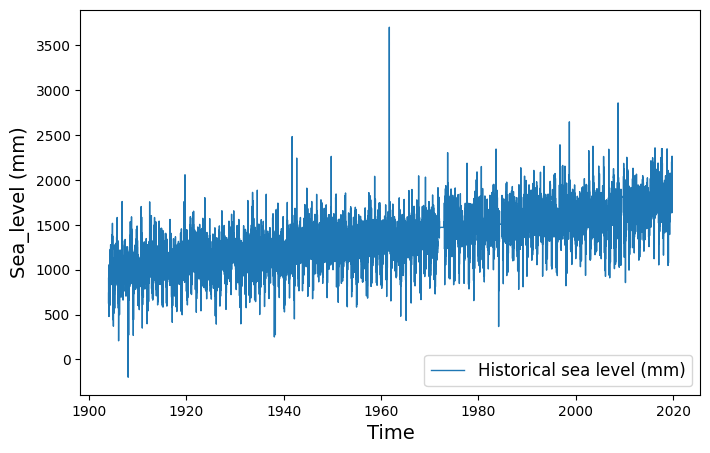

In [4]:
series = (
    series
    .sort_index(ascending=True)
    .astype(float)
    .fillna(method='ffill')
    .dropna()
    .loc[pd.to_datetime("1904"):]
)
###############################################################################
fig = plt.figure(figsize=(8,5))

plt.plot( series, linewidth= 1 )
plt.legend(["Historical sea level (mm)"], loc ="lower right", fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Sea_level (mm)', fontsize=14)
#fig.savefig('/Users/yuhan/Desktop/sealevel_raw.jpg', bbox_inches='tight', dpi=300)

plt.show()

In [5]:
nan_df = series.isna()
No_value_Year = np.unique( series[nan_df].index.year.tolist() )
print( "No values Year", No_value_Year, "\nlength of series ", len(series))

No values Year [] 
length of series  42307


In [162]:
timeseries01 = series.loc[pd.to_datetime("1904"):pd.to_datetime("1972")] 
timeseries02 = series.loc[pd.to_datetime("1973"): ] 
timeseries02.index = timeseries02.index - pd.DateOffset(years=1)

#timeseries03 = series.loc[pd.to_datetime("2008"): pd.to_datetime("2009")] 


frames = [ timeseries01, timeseries02 ]
series2 = pd.concat(frames)
#nan_df = timeseries02.isna().any(axis=1)
#print( timeseries02[nan_df] )

print( series2.head() )



Times
1904-01-02 12:00:00    739.0
1904-01-03 12:00:00    622.0
1904-01-04 12:00:00    750.0
1904-01-05 12:00:00    832.0
1904-01-06 12:00:00    911.0
Name: sea_level, dtype: float64


In [6]:
def adf_test(series):
    result = adfuller(series.resample("1M").max())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

adf_test( series  )


ADF Statistic: -0.9873074305814575
p-value: 0.757865428509344
Critical Values: {'1%': -3.435146215961187, '5%': -2.863658170584869, '10%': -2.5678977133008494}


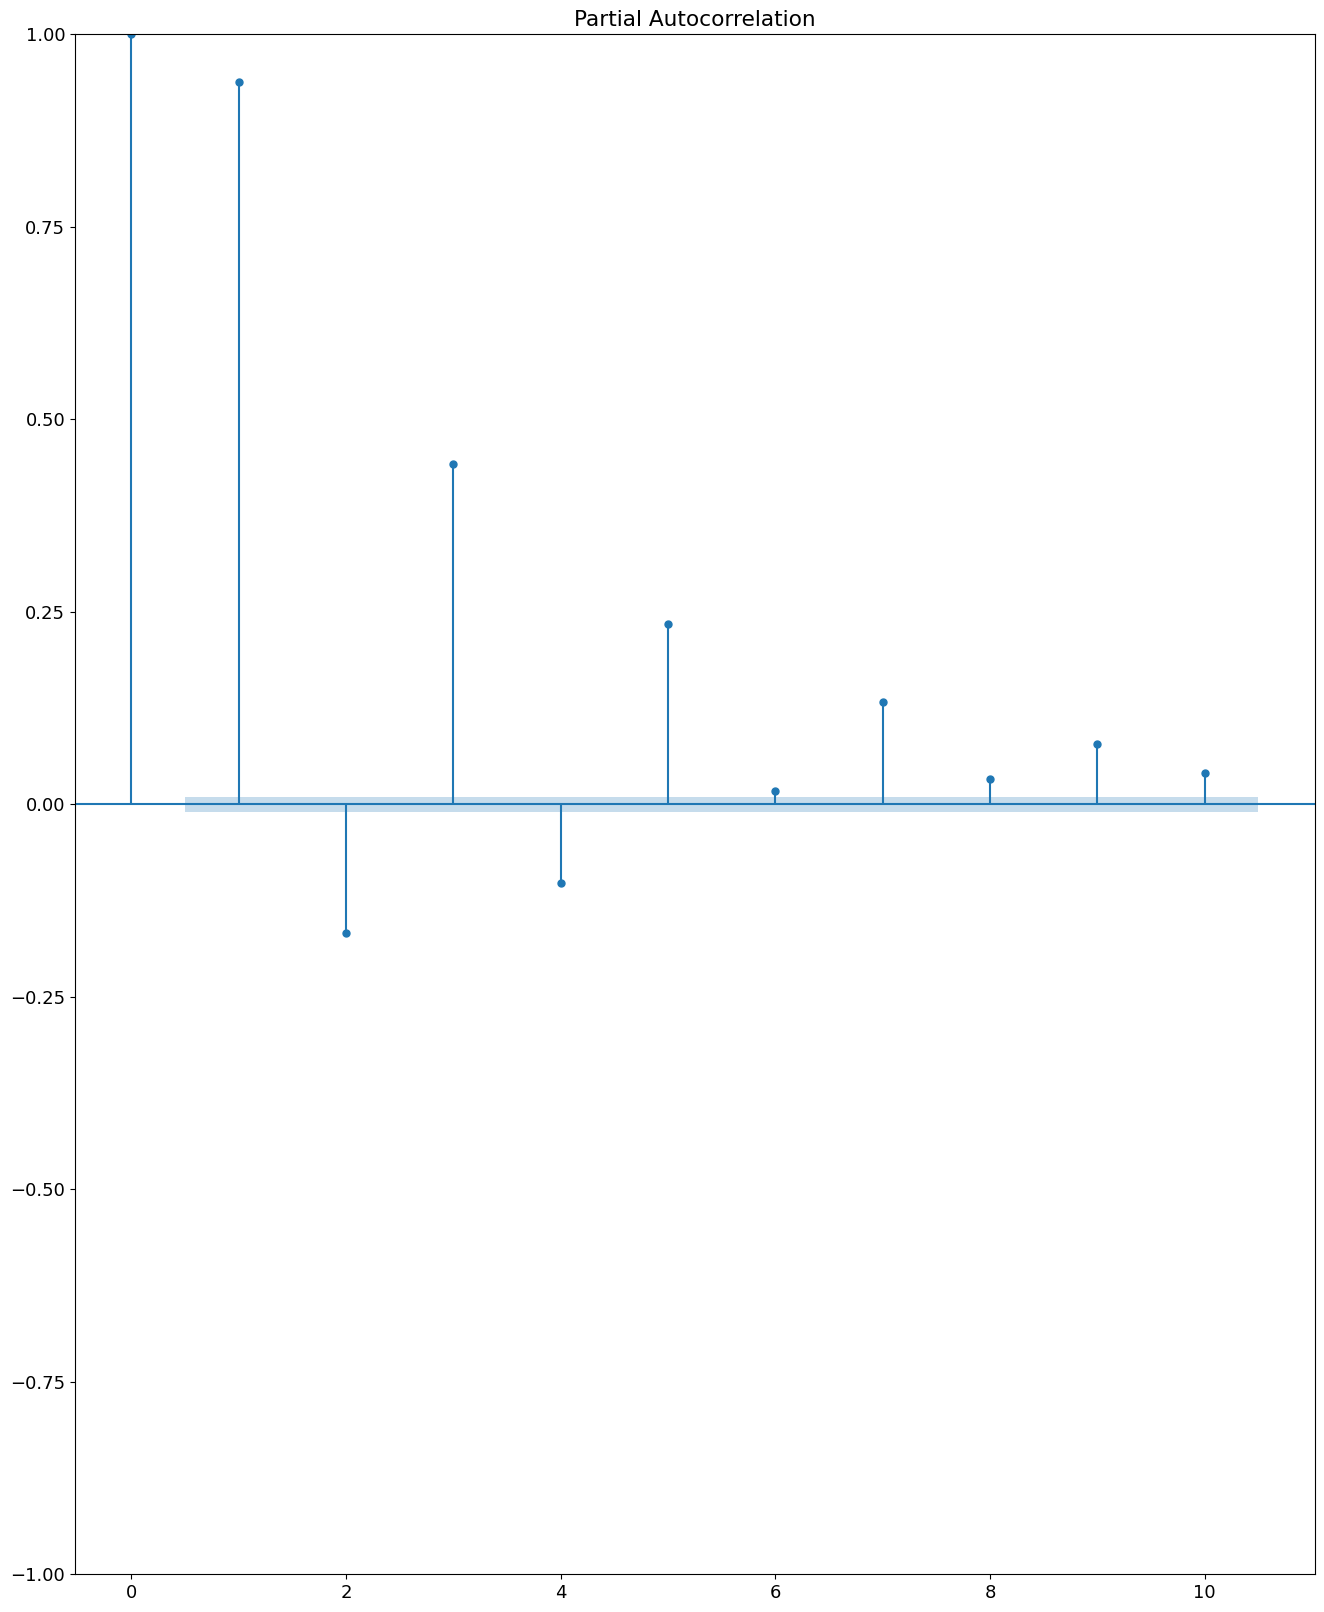

In [98]:
#AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf( series, lags = 10)
plt.show()

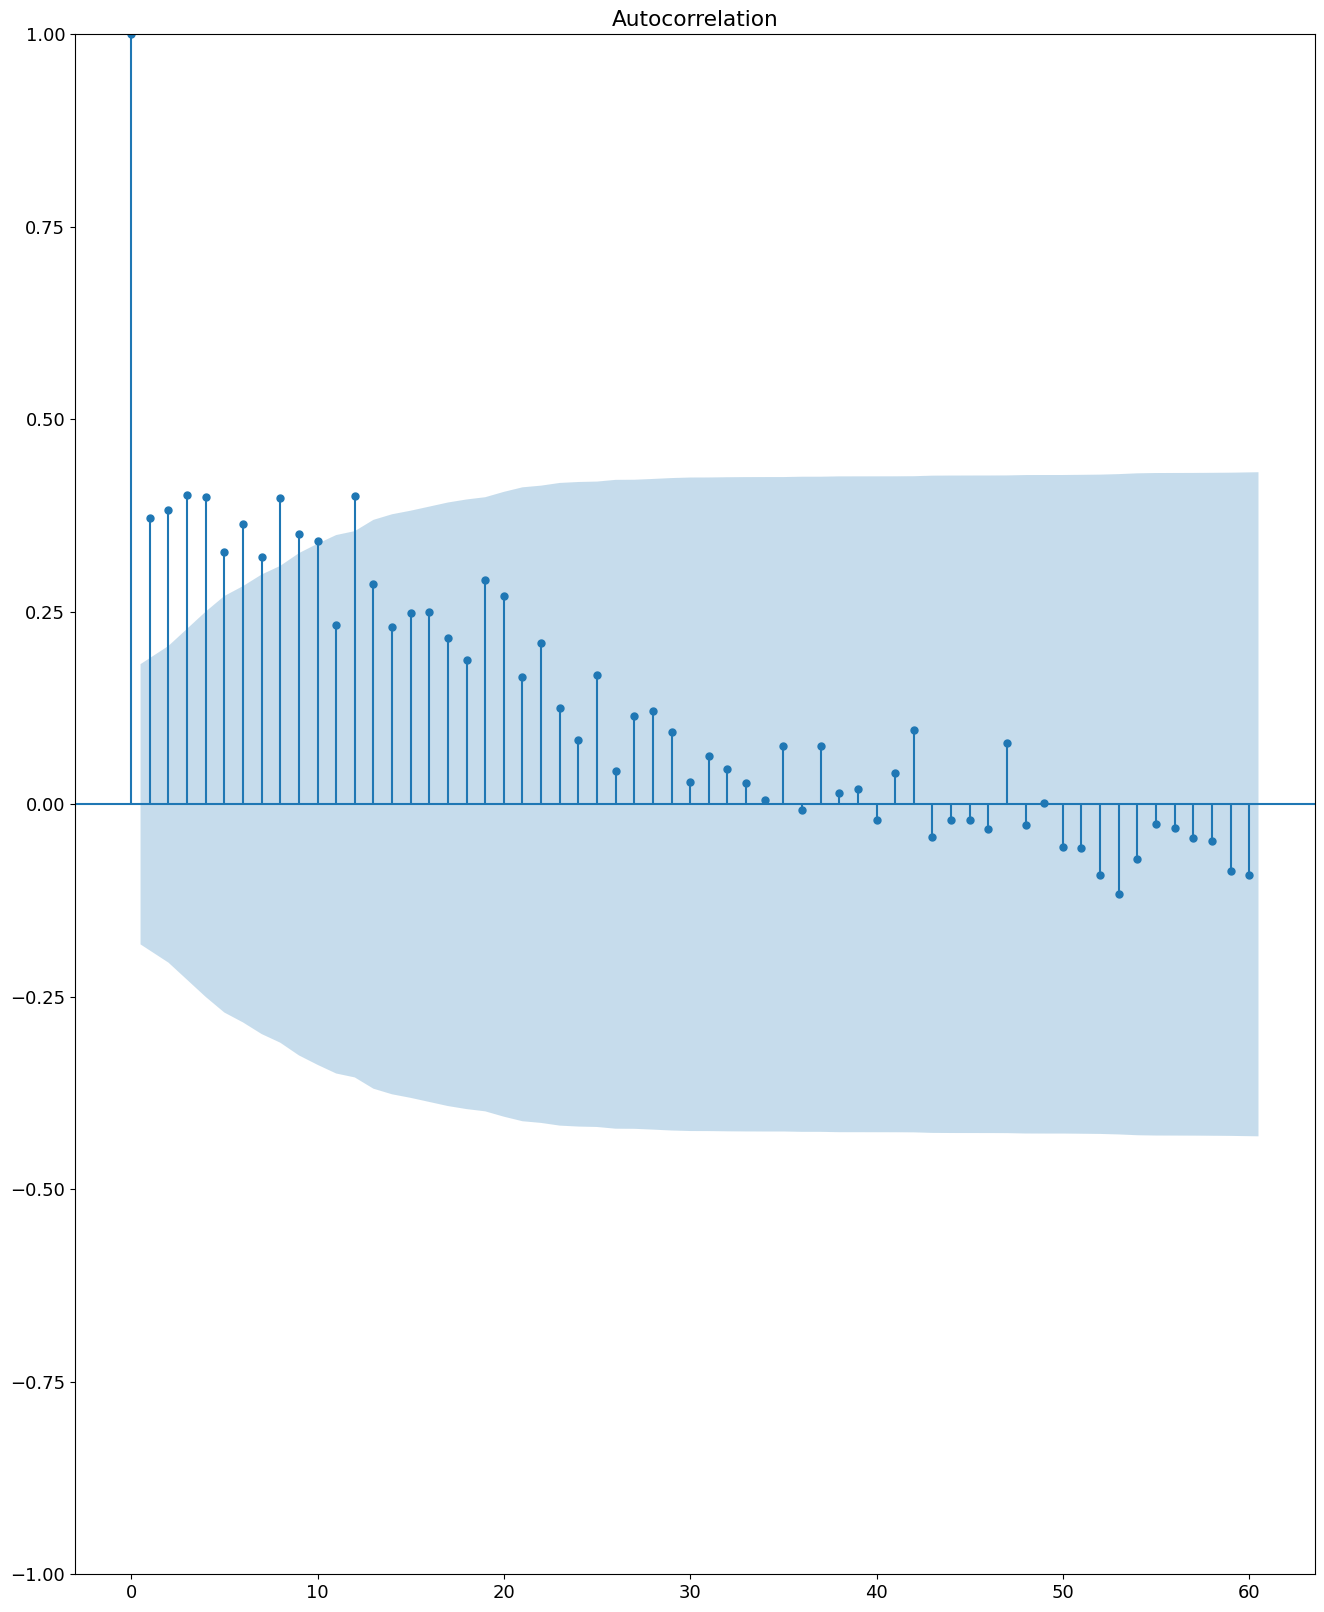

In [40]:
#MA
plot_acf(series.resample('Y').max(), lags = 60)
plt.show()

In [7]:
mstl = MSTL( series, periods=( 30, 365 ), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit() 

In [97]:
#res.seasonal.head()
#seasonal_resid = res.resid + res.seasonal
res.seasonal.head()



,seasonal_30,seasonal_365
Times,,
1904-01-02 12:00:00,-70.615025,-80.854373
1904-01-03 12:00:00,-79.842767,-57.839751
1904-01-04 12:00:00,-17.624435,-101.458087
1904-01-05 12:00:00,73.409442,-174.015344
1904-01-06 12:00:00,97.736673,-175.362452


In [9]:
def adf_test(series):
    result = adfuller(series.resample("1M").max())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])


removed_trends = series.subtract(res.trend, fill_value=0)
adf_test( removed_trends  )

#when the test statistic is lower than the critical value shown, 
#we reject the null hypothesis and infer that the time series is stationary.
#the adfuller() function in statsmodels.tsa.stattools

ADF Statistic: -7.3698593950739175
p-value: 9.031454761619631e-11
Critical Values: {'1%': -3.435146215961187, '5%': -2.863658170584869, '10%': -2.5678977133008494}


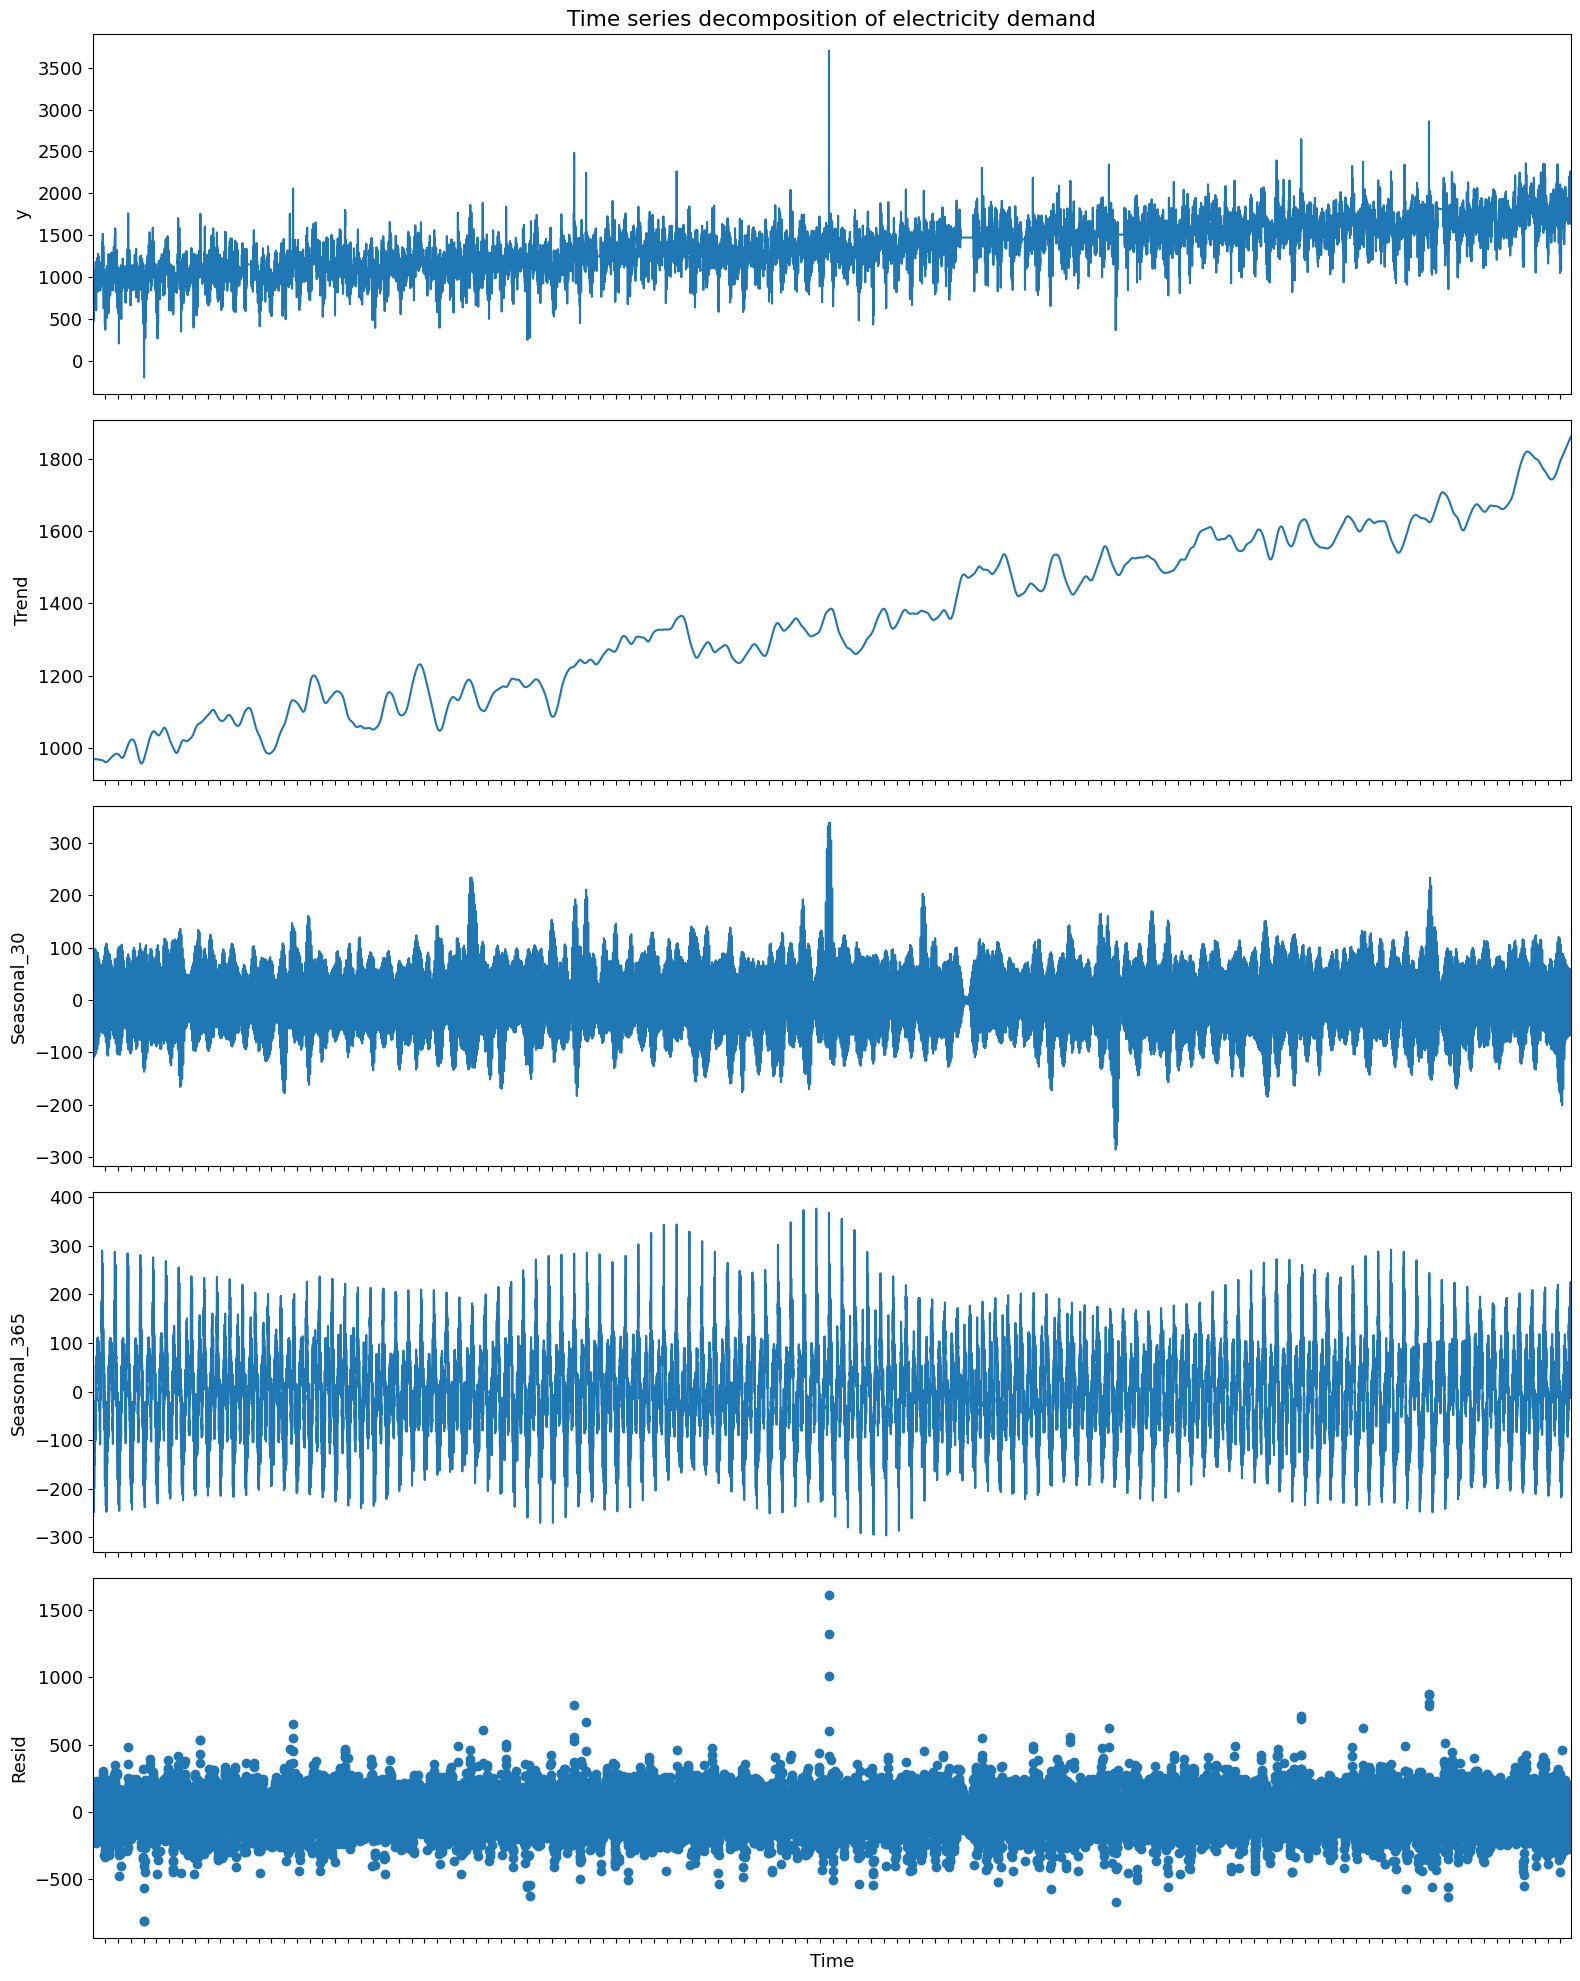

In [96]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="1904-01-02", freq= "BYS", periods= 115))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")
for ax in axs[:-1]:
    ax.get_shared_x_axes().join(ax, ax_last)
    ax.xaxis.set_ticks(pd.date_range(start="1904-01-02", freq= "BYS", periods= 115))
    ax.set_xticklabels([])
axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of electricity demand")
ax_last.set_xlabel("Time")

plt.tight_layout()

In [30]:
'''figure, axis = plt.subplots(2, 2, figsize=( 14, 5)) 
# For Sine Function 
axis[0, 0].plot( res.trend ) 
axis[0, 0].set_title("", size = 10) 
# For Cosine Function 
axis[0, 1].plot( res.seasonal.seasonal_7 ) 
axis[0, 1].set_title("") 
# For Tangent Function 
axis[1, 0].plot( res.seasonal.seasonal_120 ) 
axis[1, 0].set_title("") 
# For Tanh Function 

axis[1, 1].plot( res.resid  ) 
axis[1, 1].set_title("") 
# Combine all the operations and display 
plt.show() '''

'figure, axis = plt.subplots(2, 2, figsize=( 14, 5)) \n# For Sine Function \naxis[0, 0].plot( res.trend ) \naxis[0, 0].set_title("", size = 10) \n# For Cosine Function \naxis[0, 1].plot( res.seasonal.seasonal_7 ) \naxis[0, 1].set_title("") \n# For Tangent Function \naxis[1, 0].plot( res.seasonal.seasonal_120 ) \naxis[1, 0].set_title("") \n# For Tanh Function \n\naxis[1, 1].plot( res.resid  ) \naxis[1, 1].set_title("") \n# Combine all the operations and display \nplt.show() '

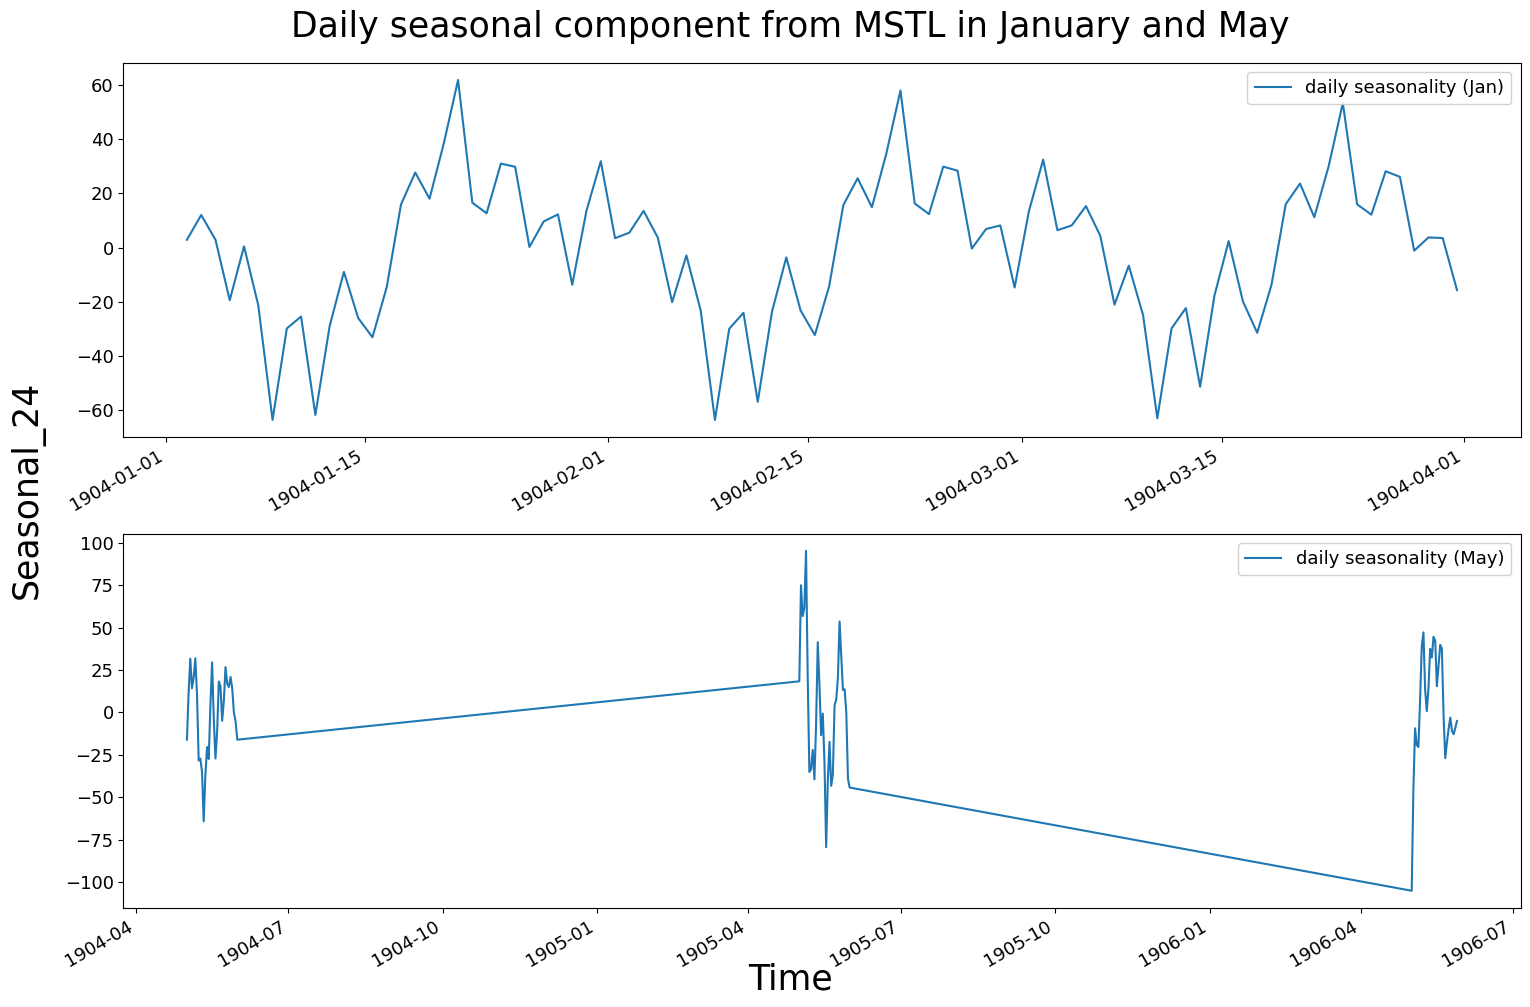

In [41]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot daily seasonality in January
res.seasonal["seasonal_31"].iloc[: 30 * 3].plot(
    ax=ax[0], label="daily seasonality (Jan)", legend=True
)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].legend(loc="upper right", framealpha=0.9)

# Plot daily seasonality in May
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_31"].iloc[: 30 * 3].plot(
    ax=ax[1], label="daily seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="upper right", framealpha=0.9)

# Figure labels
fig.suptitle("Daily seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_24", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

In [93]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose( series, model='additive',extrapolate_trend='freq')
#result.plot()
#plt.show()

<Axes: xlabel='Times'>

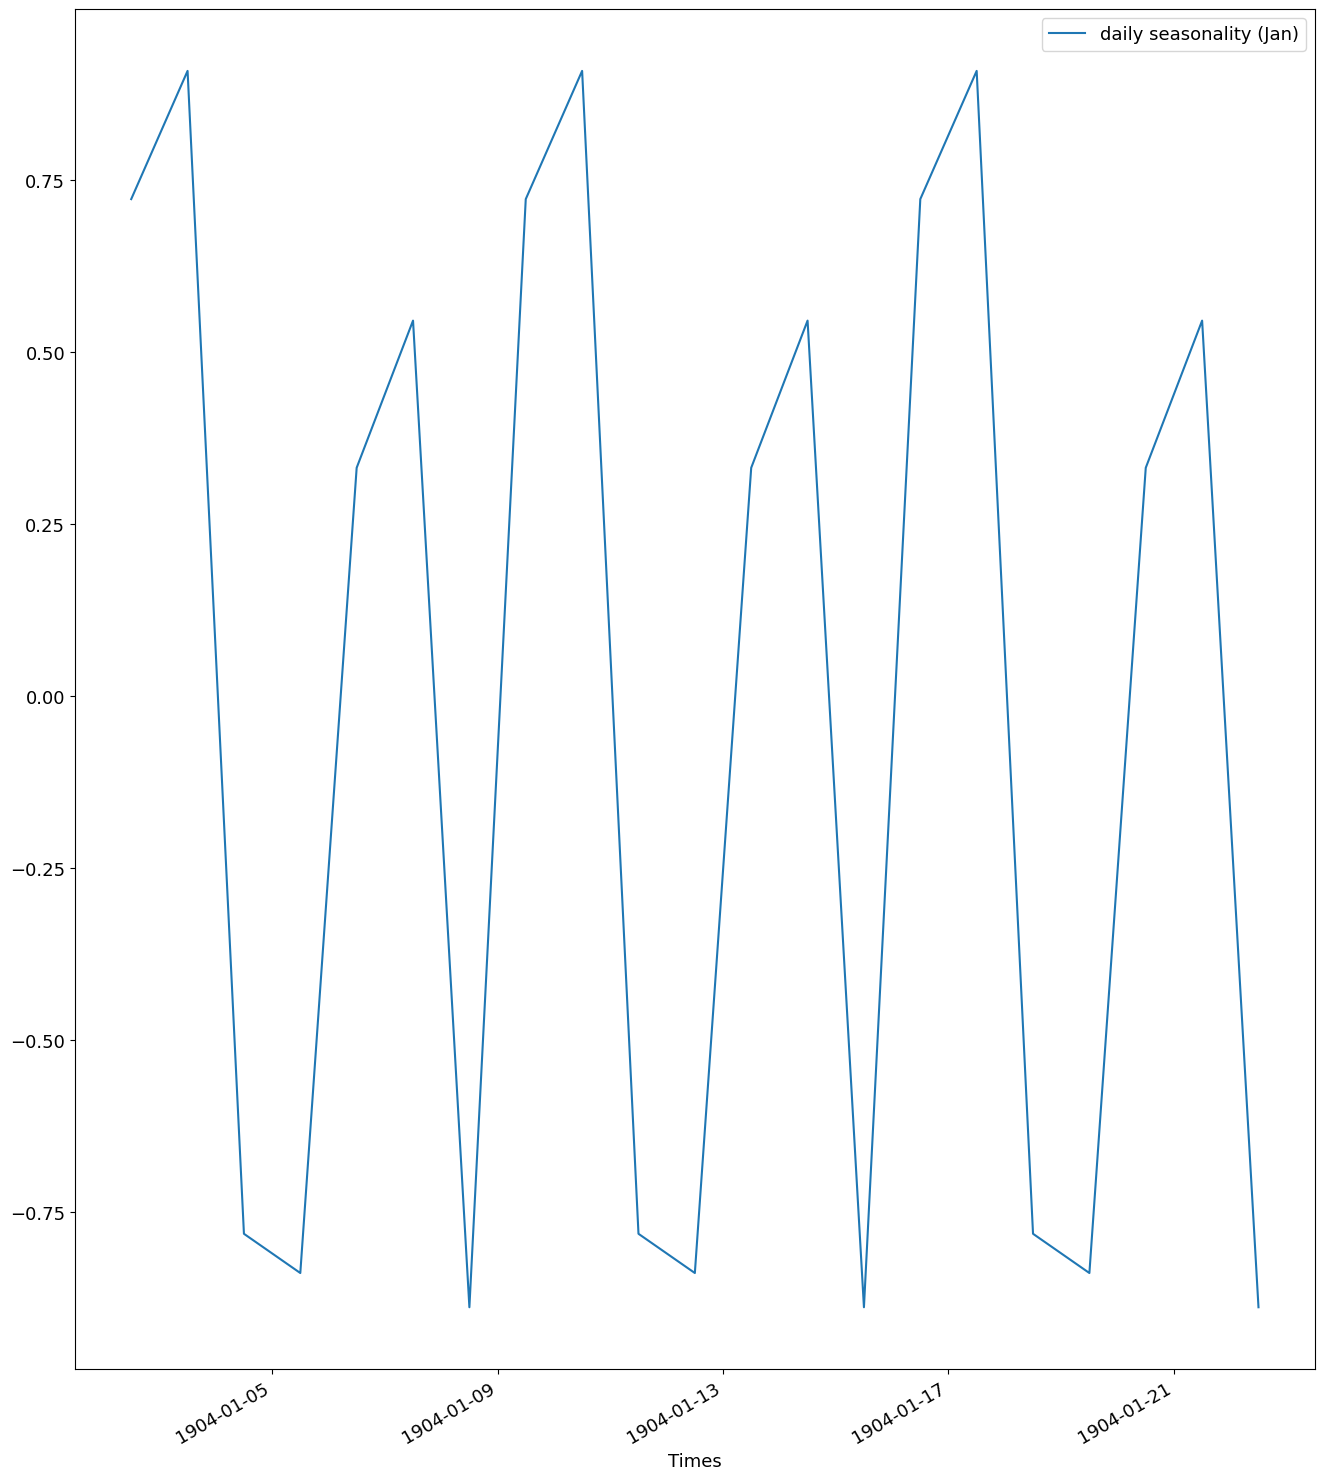

In [10]:
result.seasonal.iloc[ : 21 ].plot( label="daily seasonality (Jan)", legend=True)


In [11]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

seasonal = result.seasonal
check_stationarity(seasonal)


The series is stationary


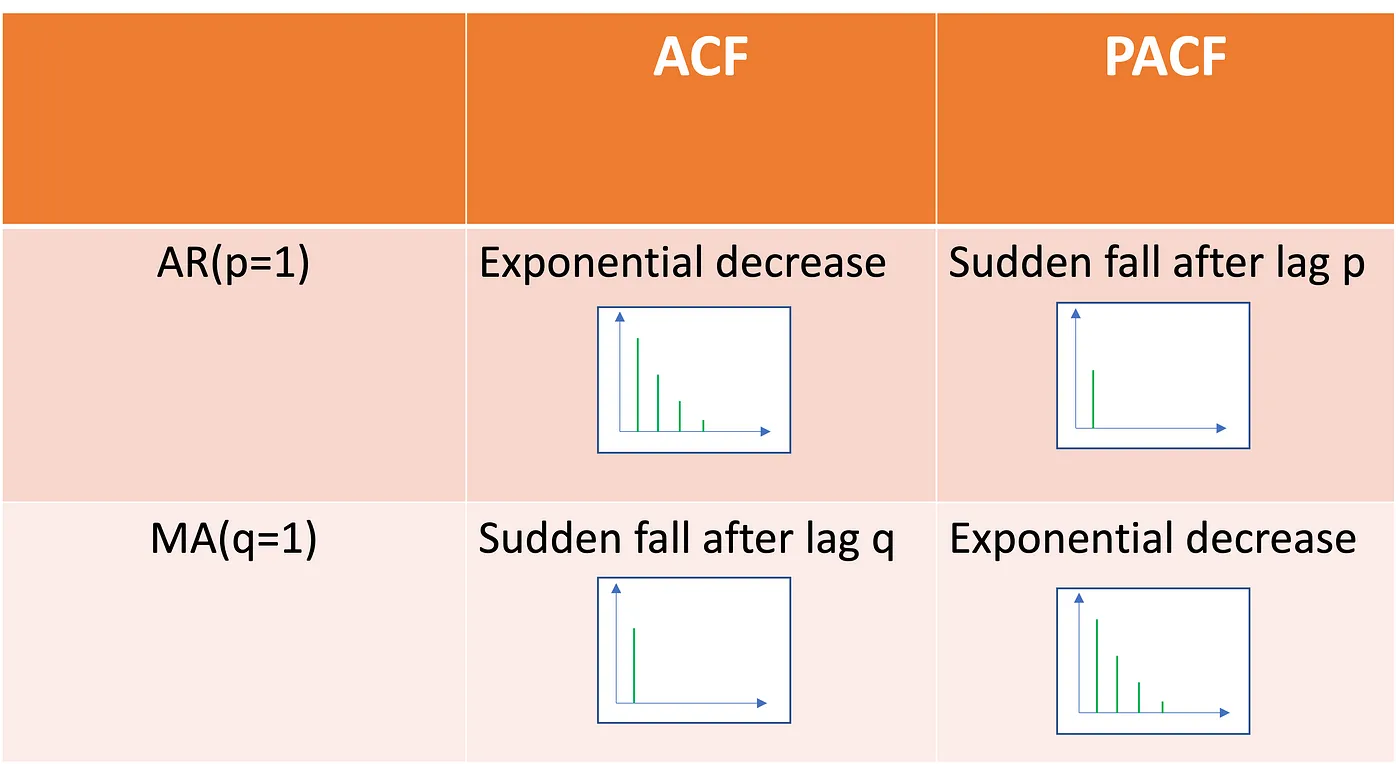

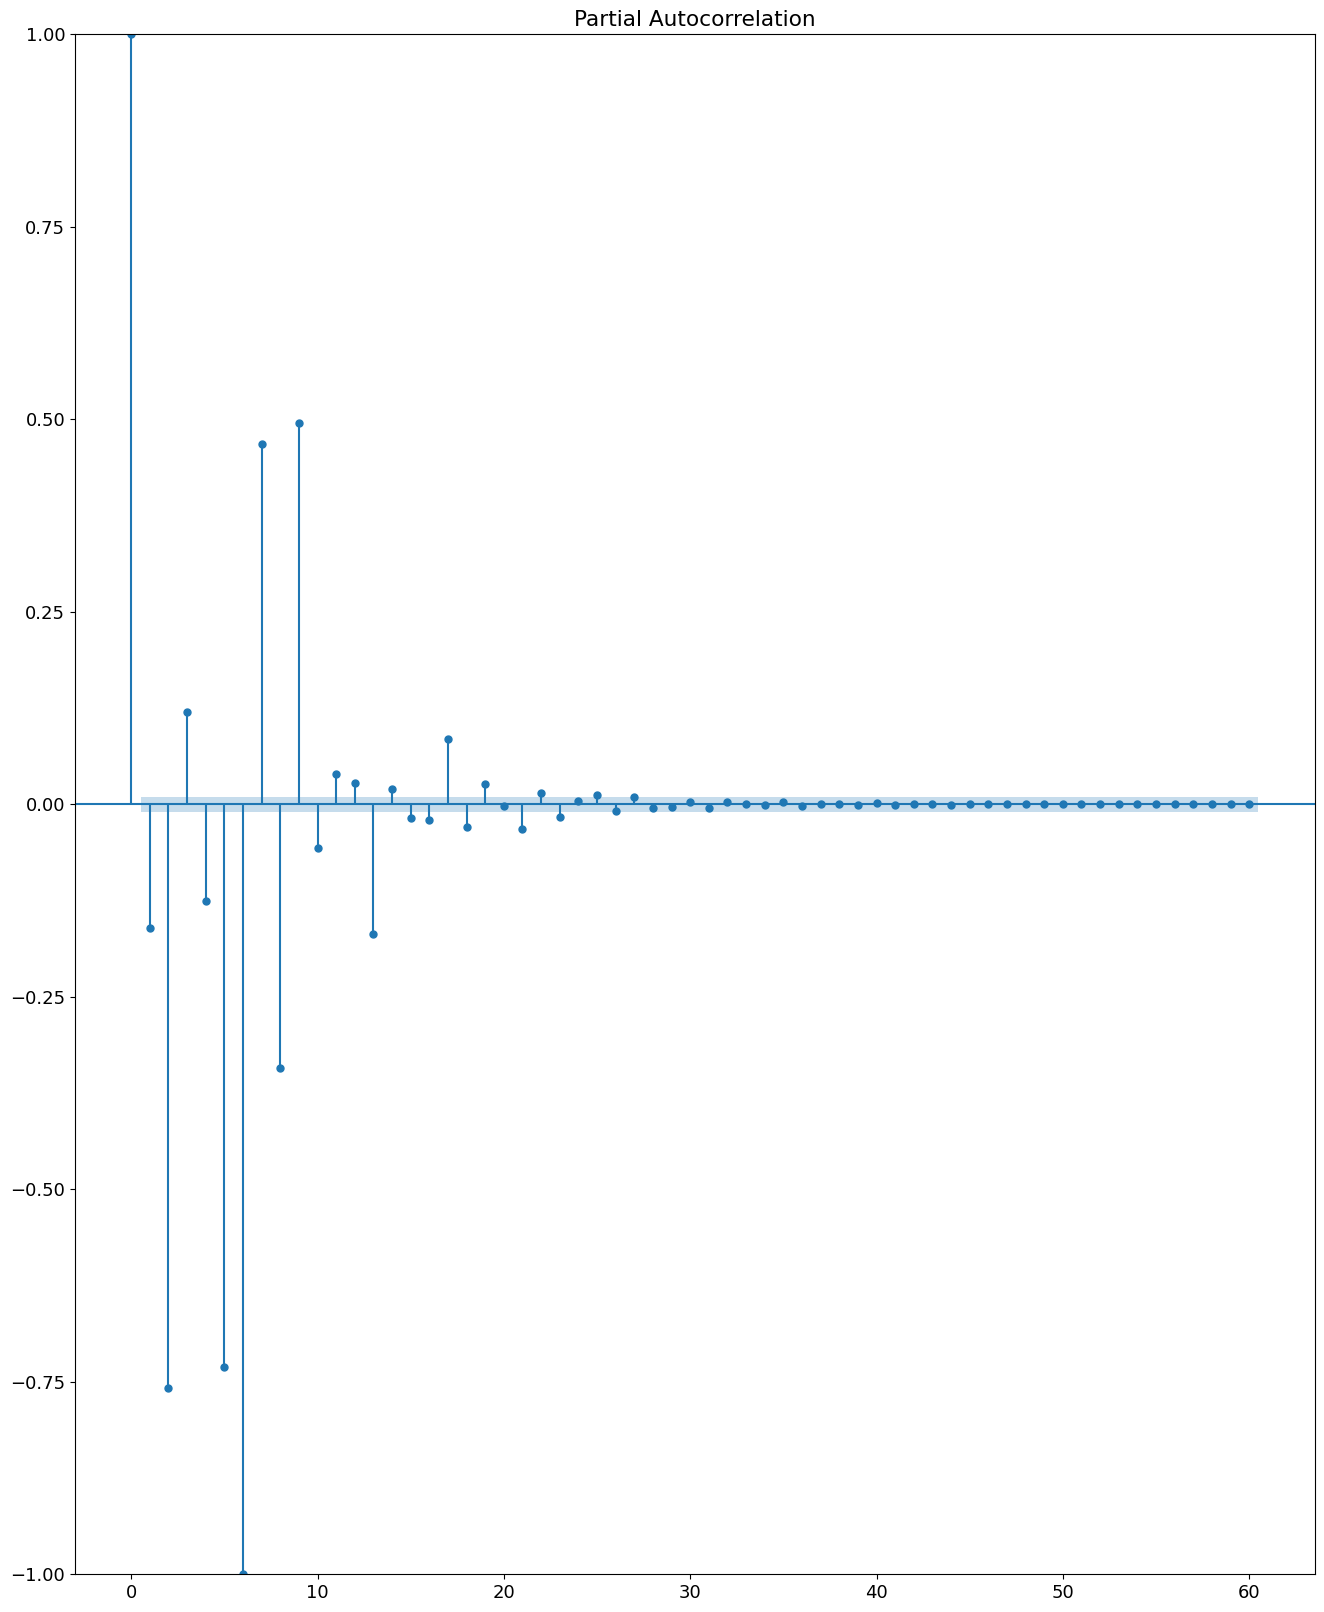

In [13]:
#AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags = 60)
plt.show()

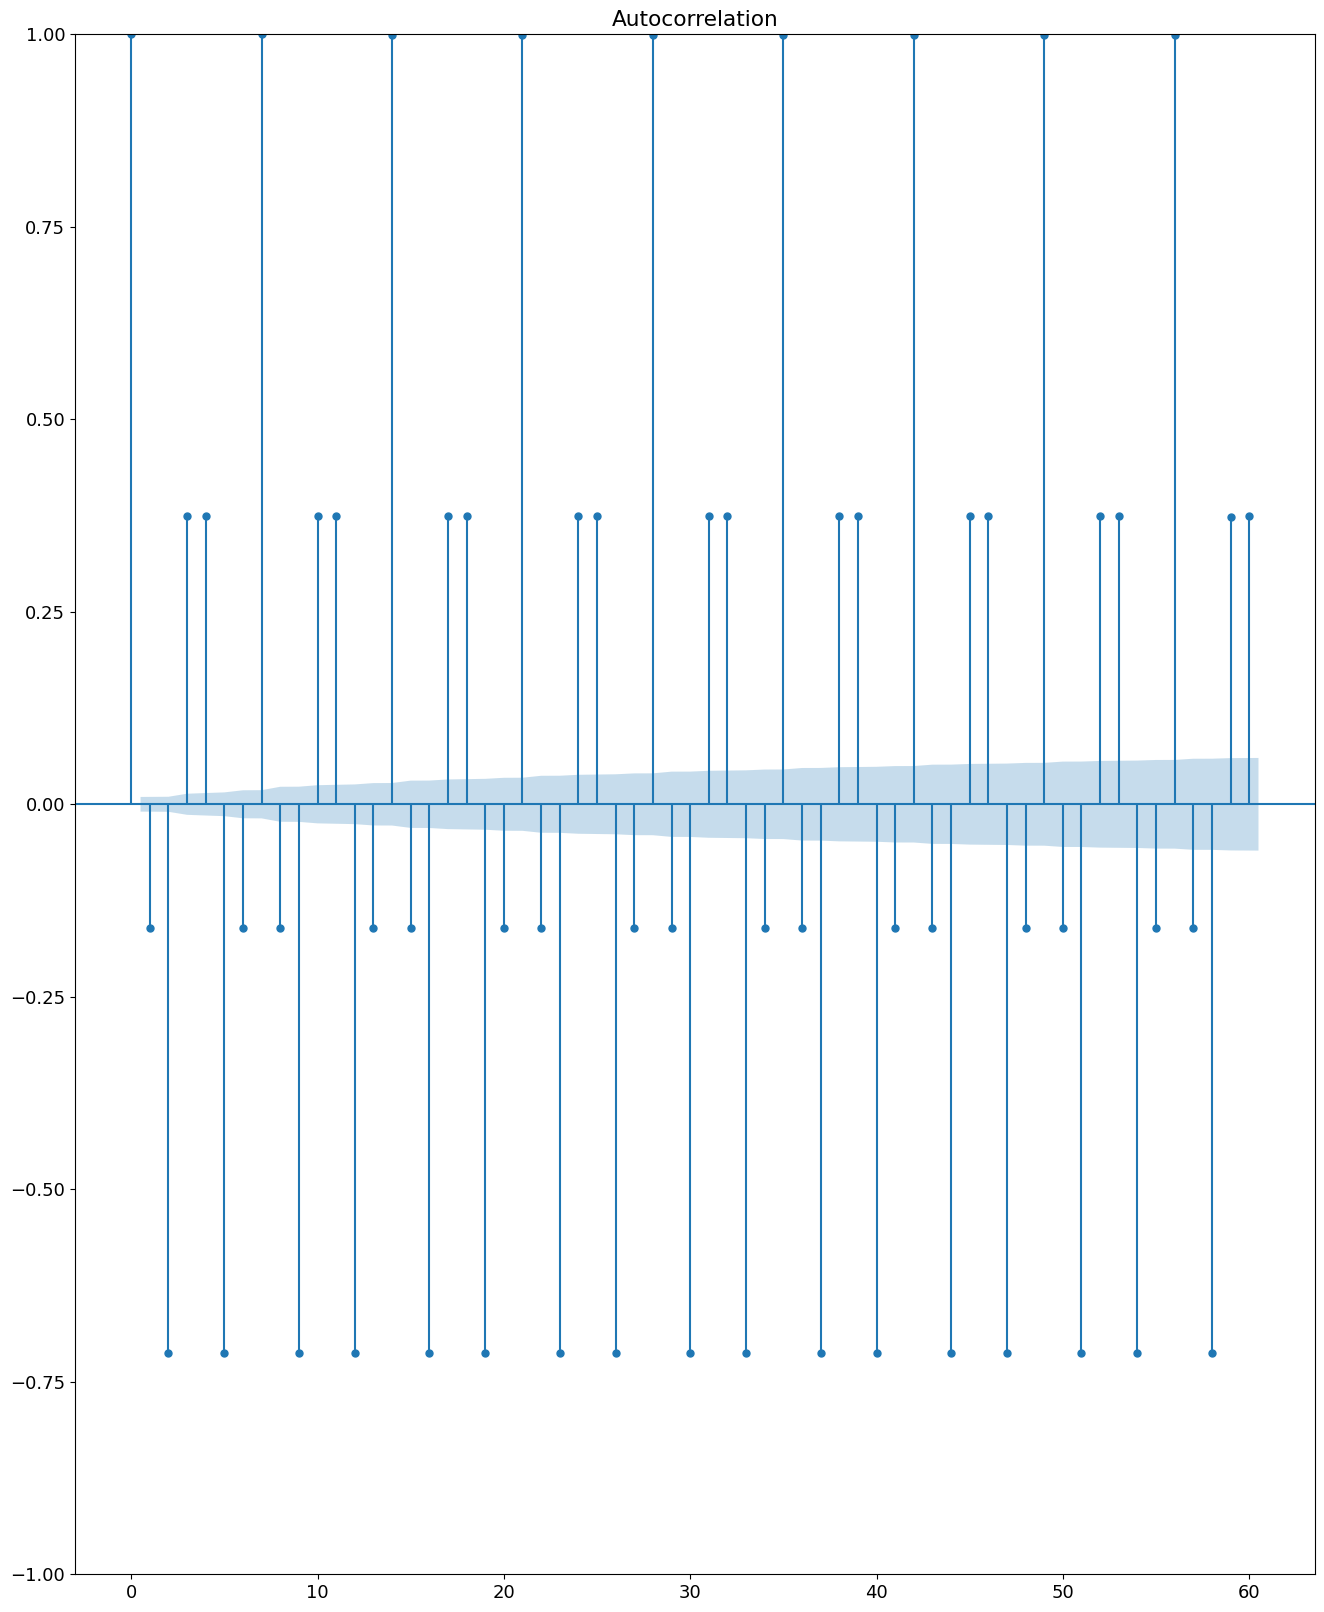

In [15]:
#MA
plot_acf(seasonal, lags = 60)
plt.show()

42307
1390


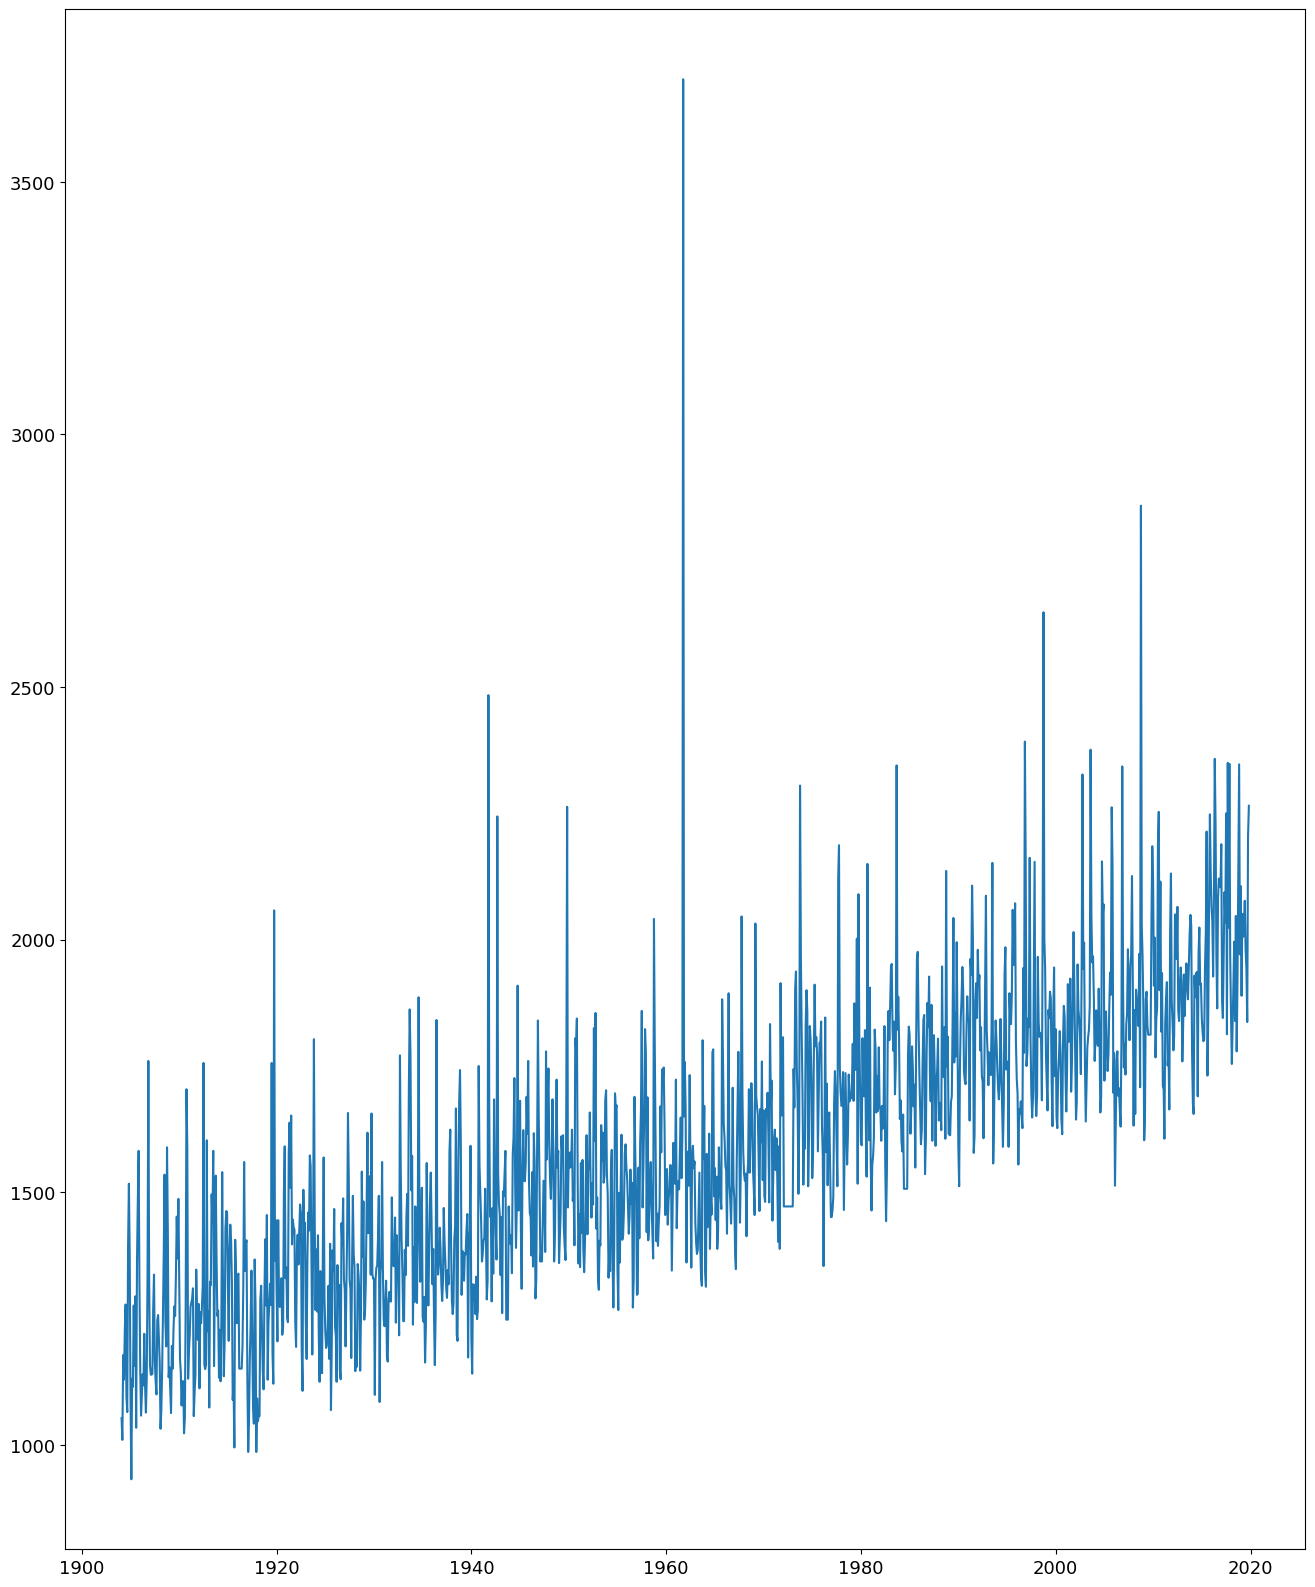

In [105]:
print( len(series) )
X    = series.resample('M').max()
print( len(X) )
plt.plot(X)

In [106]:
X0    = series.resample('M').max()
X0

Times
1904-01-31    1053.0
1904-02-29    1010.0
1904-03-31    1178.0
1904-04-30    1129.0
1904-05-31    1227.0
               ...  
2019-06-30    1982.0
2019-07-31    1943.0
2019-08-31    1837.0
2019-09-30    2203.0
2019-10-31    2265.0
Freq: M, Name: sea_level, Length: 1390, dtype: float64

In [109]:

mstl = MSTL( X0, periods=( 4, 12 ), stl_kwargs={"seasonal_deg": 0})
res  = mstl.fit() 


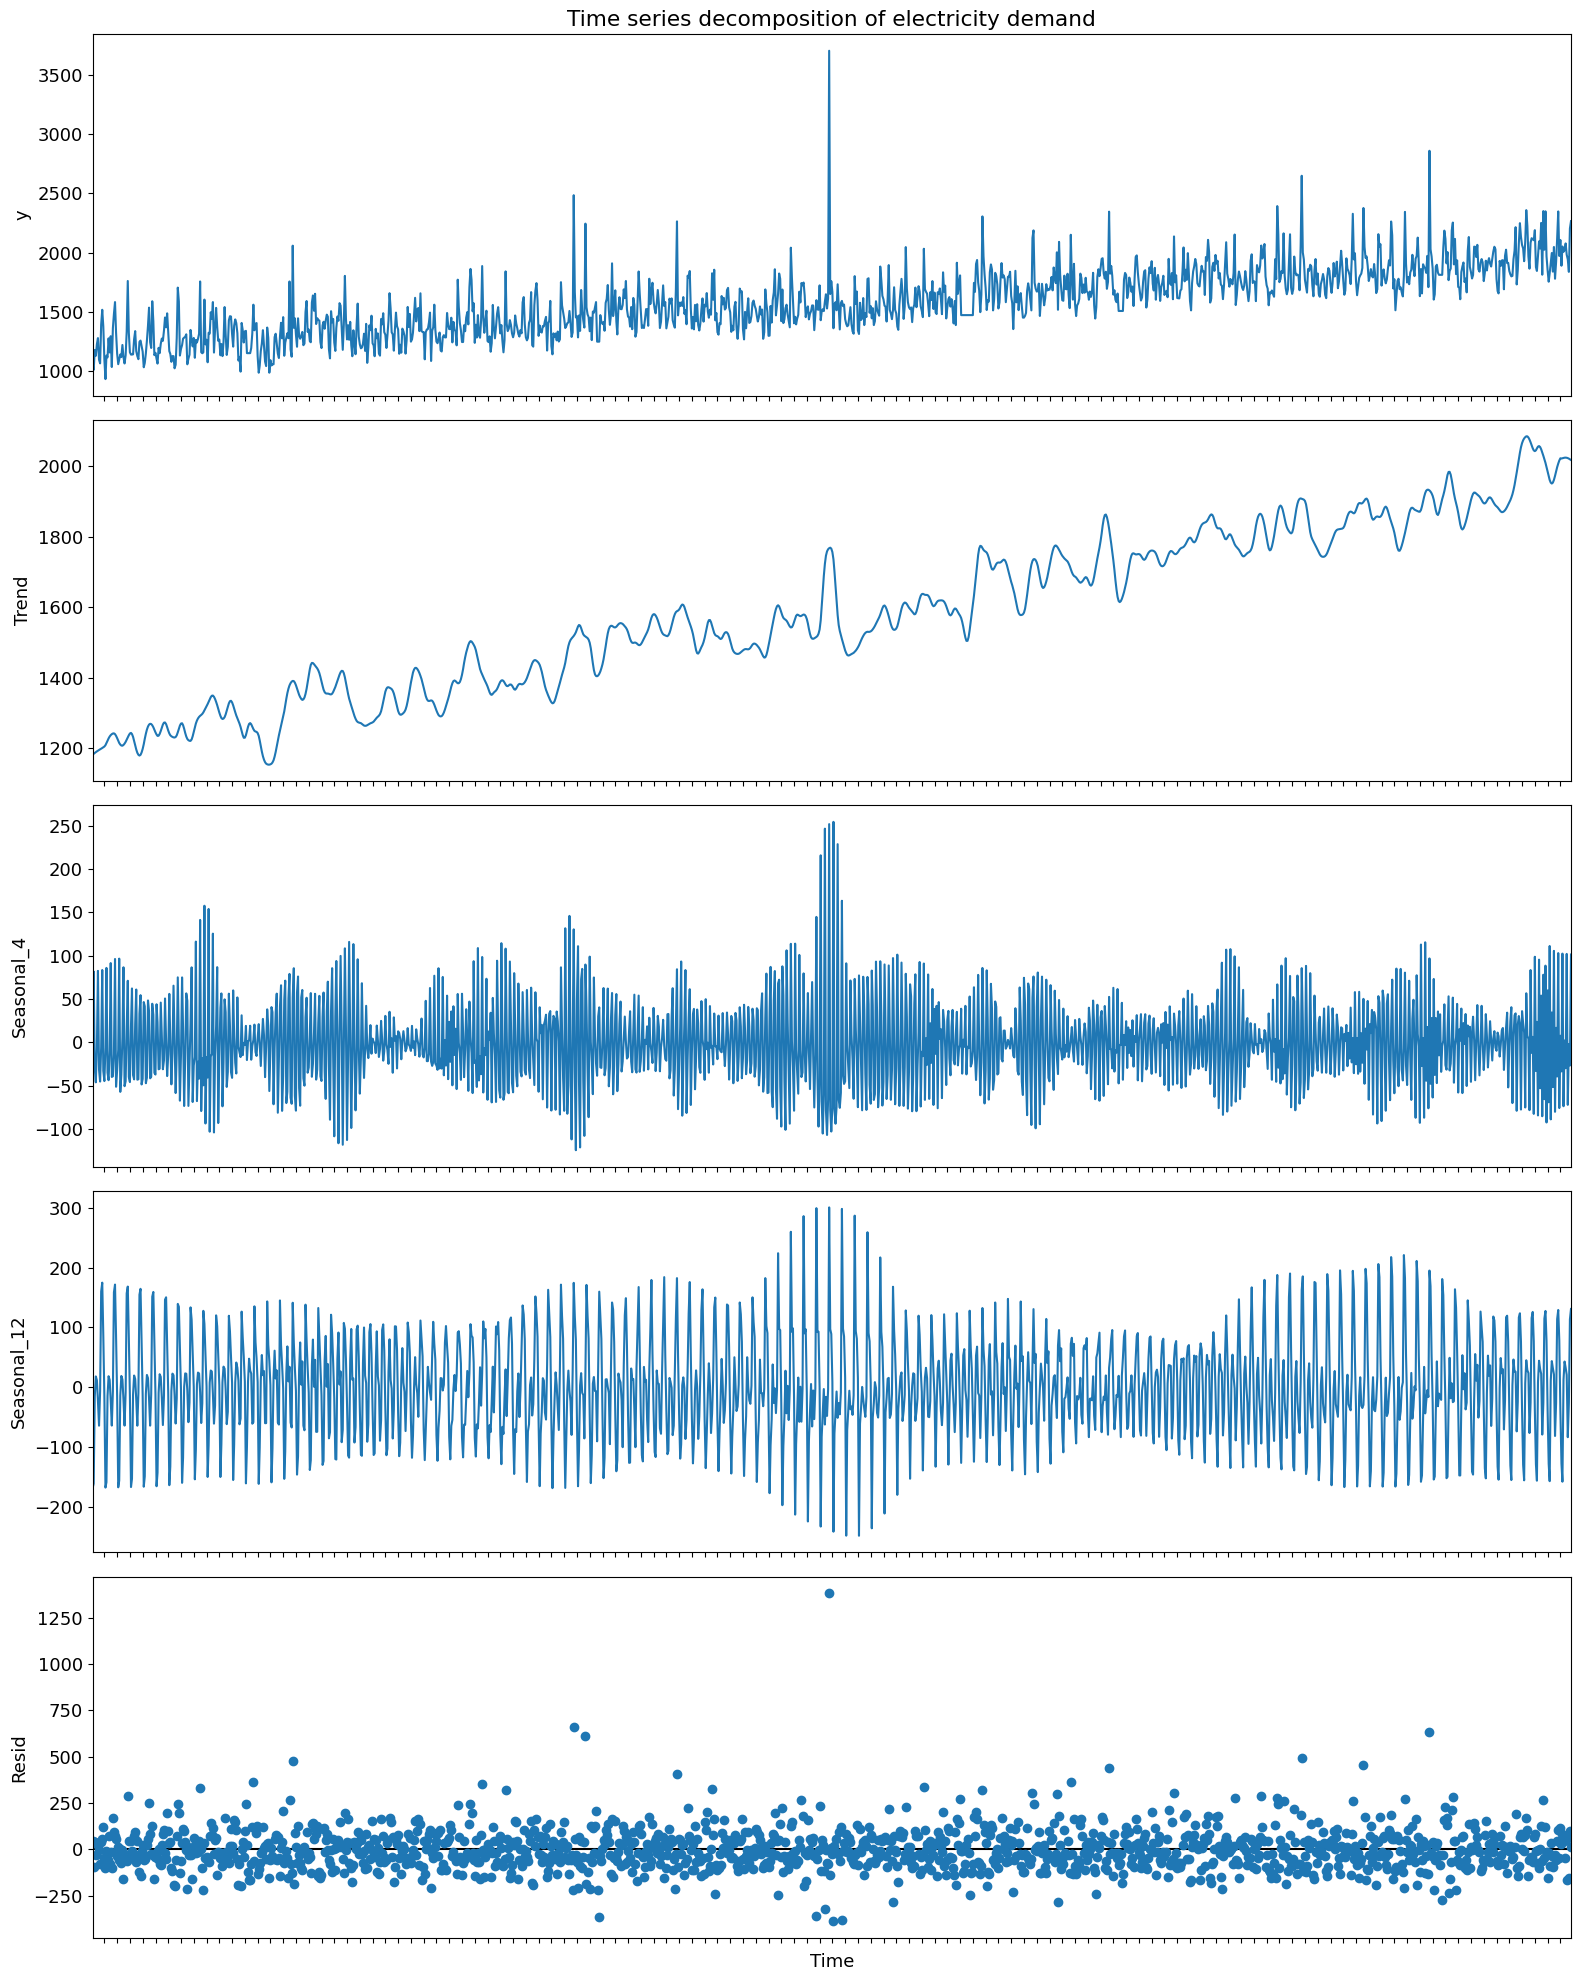

In [110]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="1904-01-02", freq= "BYS", periods= 115))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")
for ax in axs[:-1]:
    ax.get_shared_x_axes().join(ax, ax_last)
    ax.xaxis.set_ticks(pd.date_range(start="1904-01-02", freq= "BYS", periods= 115))
    ax.set_xticklabels([])
axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of electricity demand")
ax_last.set_xlabel("Time")

plt.tight_layout()

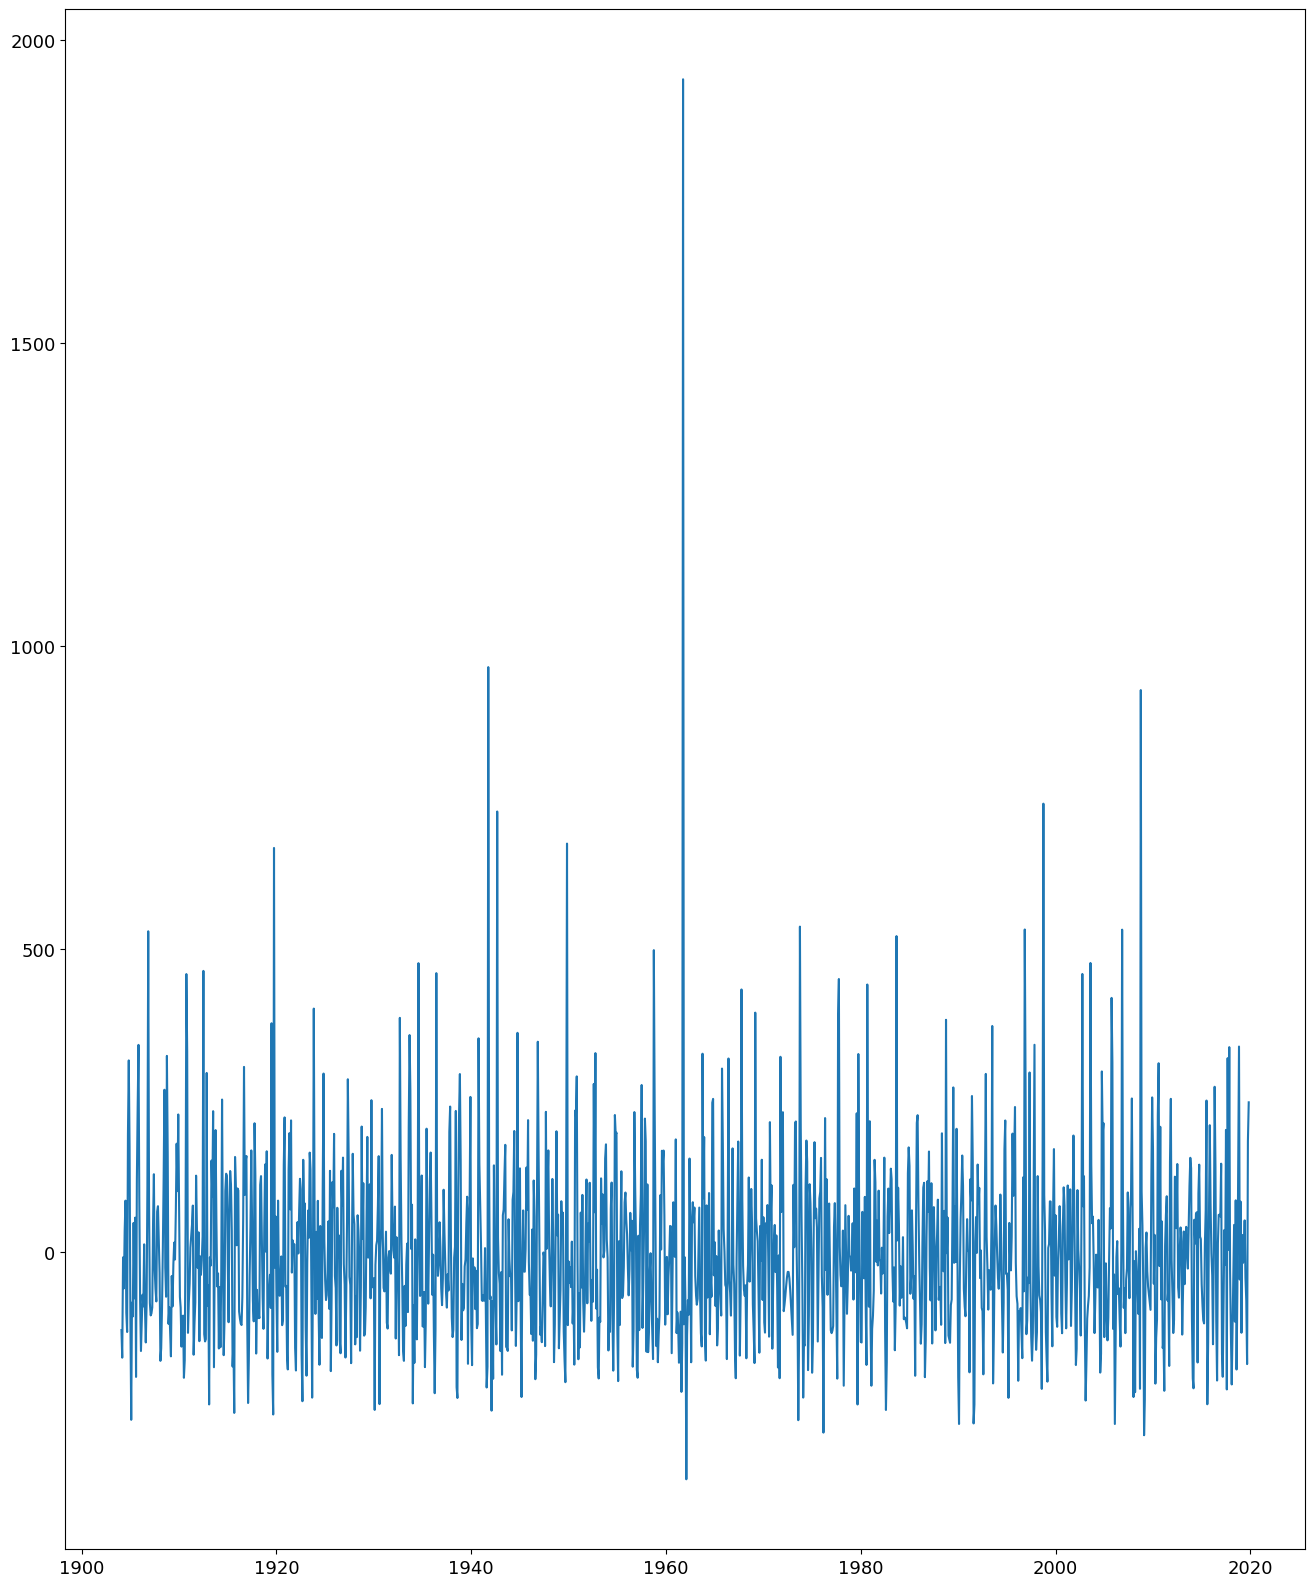

In [111]:
plt.plot( X0 - res.trend )

In [119]:
np.arange(len(res.trend))
x = np.array( res.trend.index.year )
future_series0 = pd.DataFrame(index= pd.date_range(start=series.index[-1], periods= 35600, freq='d' ) )
print( len(future_series0) )

future_series = future_series0.resample('M').max()
print( len(future_series) )

x_future = np.array(future_series.index.year)

35600
1171


In [120]:

from sklearn.linear_model import LinearRegression

trend_model = LinearRegression().fit( x.reshape(-1, 1), res.trend)
trend_model.coef_, trend_model.intercept_

x_pred = x_future.reshape(-1, 1)
y_pred = trend_model.predict( x_pred )
#y_pred
#plt.plot( y_pred )
print(len(y_pred))

1171


In [115]:

time = series.index
print(len(series))
X    = X0 - res.trend
print(len(X))

train, test   = X[1:len(X)- 20 ], X[len(X)- 20:]
trainT, testT = time[1:len(X) -  20], time[len(X)- 20:]



42307
1390


In [20]:

ARIMAmodel = ARIMA(train, order = ( 4, 1, 7))
ARIMAmodel = ARIMAmodel.fit()


In [183]:
#(p,d,q) Order Autoregressive, the Moving Average, and the stationarity 
#p: Autoregressive order.
#d: Differencing order.
#q: Moving average order.
#(P,D,Q,M)
#P: Seasonal autoregressive order.
#D: Seasonal differencing order.
#Q: Seasonal moving average order
#S: Length of the seasonal cycle.


In [90]:
future_dates = pd.date_range(start= X.index[-1], periods= 50, freq='y')
total_predict_dates = test.index.union(future_dates)
y_pred = ARIMAmodel.get_forecast(len( total_predict_dates)   )
y_pred_df = y_pred.conf_int(alpha = 0.5) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = total_predict_dates[0], 
                                              end = total_predict_dates[-1])

y_pred_df.index = total_predict_dates
y_pred_out = y_pred_df["Predictions"] 

print("RMSE: ",ARIMAmodel)

arma_rmse = np.sqrt(mean_squared_error( test.values, y_pred_df["Predictions"][:len(test.values)]))
print("RMSE: ", arma_rmse)


RMSE:  <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x2b84c8810>
RMSE:  220.19113706144762


In [118]:
SARIMAXmodel1 = SARIMAX(train, order = (1, 1, 1), seasonal_order=( 1, 1, 1, 4 ))
SARIMAXmodel1 = SARIMAXmodel1.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79125D+00    |proj g|=  8.78553D-02

At iterate    5    f=  6.69635D+00    |proj g|=  6.42869D-03


 This problem is unconstrained.



At iterate   10    f=  6.68553D+00    |proj g|=  2.53167D-03

At iterate   15    f=  6.41267D+00    |proj g|=  3.44086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     38      1     0     0   3.166D-05   6.413D+00
  F =   6.4126539404971314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [117]:
SARIMAXmodel2 = SARIMAX(train, order = (1, 1, 1), seasonal_order=( 1, 1, 1, 12 ))
SARIMAXmodel2 = SARIMAXmodel2.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56446D+00    |proj g|=  6.51615D-02


 This problem is unconstrained.



At iterate    5    f=  6.49392D+00    |proj g|=  1.20388D-02

At iterate   10    f=  6.47771D+00    |proj g|=  2.79133D-03

At iterate   15    f=  6.28768D+00    |proj g|=  8.65065D-02

At iterate   20    f=  6.28003D+00    |proj g|=  4.83761D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     32      1     0     0   4.838D-05   6.280D+00
  F =   6.2800267587716485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [121]:
future_series.index[-1]
future_dates = pd.date_range(start= future_series.index[-1], periods= len(future_series), freq='w')
len(future_dates)

1171

In [122]:

#future_dates = pd.date_range(start= future_series.index[-1], periods= 50, freq='w')
total_predict_dates = test.index.union(future_dates)

y_pred2 = SARIMAXmodel1.get_forecast( len( total_predict_dates)  )
y_pred_df2 = y_pred2.conf_int(alpha = 0.05) 
y_pred_df2["Predictions"] = SARIMAXmodel1.predict(start = total_predict_dates[0], 
                                                 end = total_predict_dates[-1])

y_pred_df2.index = total_predict_dates 
y_pred_out2 = y_pred_df2["Predictions"] 

print("RMSE: ", SARIMAXmodel1)

SARIMAX_rmse = np.sqrt(mean_squared_error( test.values, 
                                           y_pred_df2["Predictions"][:len(test.values)]))
print("RMSE: ", SARIMAX_rmse)


RMSE:  <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x2a780b550>
RMSE:  129.30036443926122


In [123]:

#future_dates = pd.date_range(start= X.index[-1], periods= 50, freq='y')
total_predict_dates = test.index.union(future_dates)

y_pred3 = SARIMAXmodel2.get_forecast( len( total_predict_dates)  )
y_pred_df3 = y_pred3.conf_int(alpha = 0.05) 
y_pred_df3["Predictions"] = SARIMAXmodel2.predict(start = total_predict_dates[0], 
                                                 end = total_predict_dates[-1])

y_pred_df3.index = total_predict_dates 
y_pred_out3 = y_pred_df3["Predictions"] 

print("RMSE: ", SARIMAXmodel2)

SARIMAX_rmse = np.sqrt(mean_squared_error( test.values, 
                                           y_pred_df3["Predictions"][:len(test.values)]))
print("RMSE: ", SARIMAX_rmse)

RMSE:  <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x2a4e04510>
RMSE:  92.18865139402666


In [124]:
y_pred

array([1965.62433902, 1965.62433902, 1965.62433902, ..., 2616.29428337,
       2616.29428337, 2616.29428337])

In [125]:

total_sum_preds = y_pred+ y_pred_df2['Predictions'][len(test.values):] + y_pred_df3['Predictions'][len(test.values):]

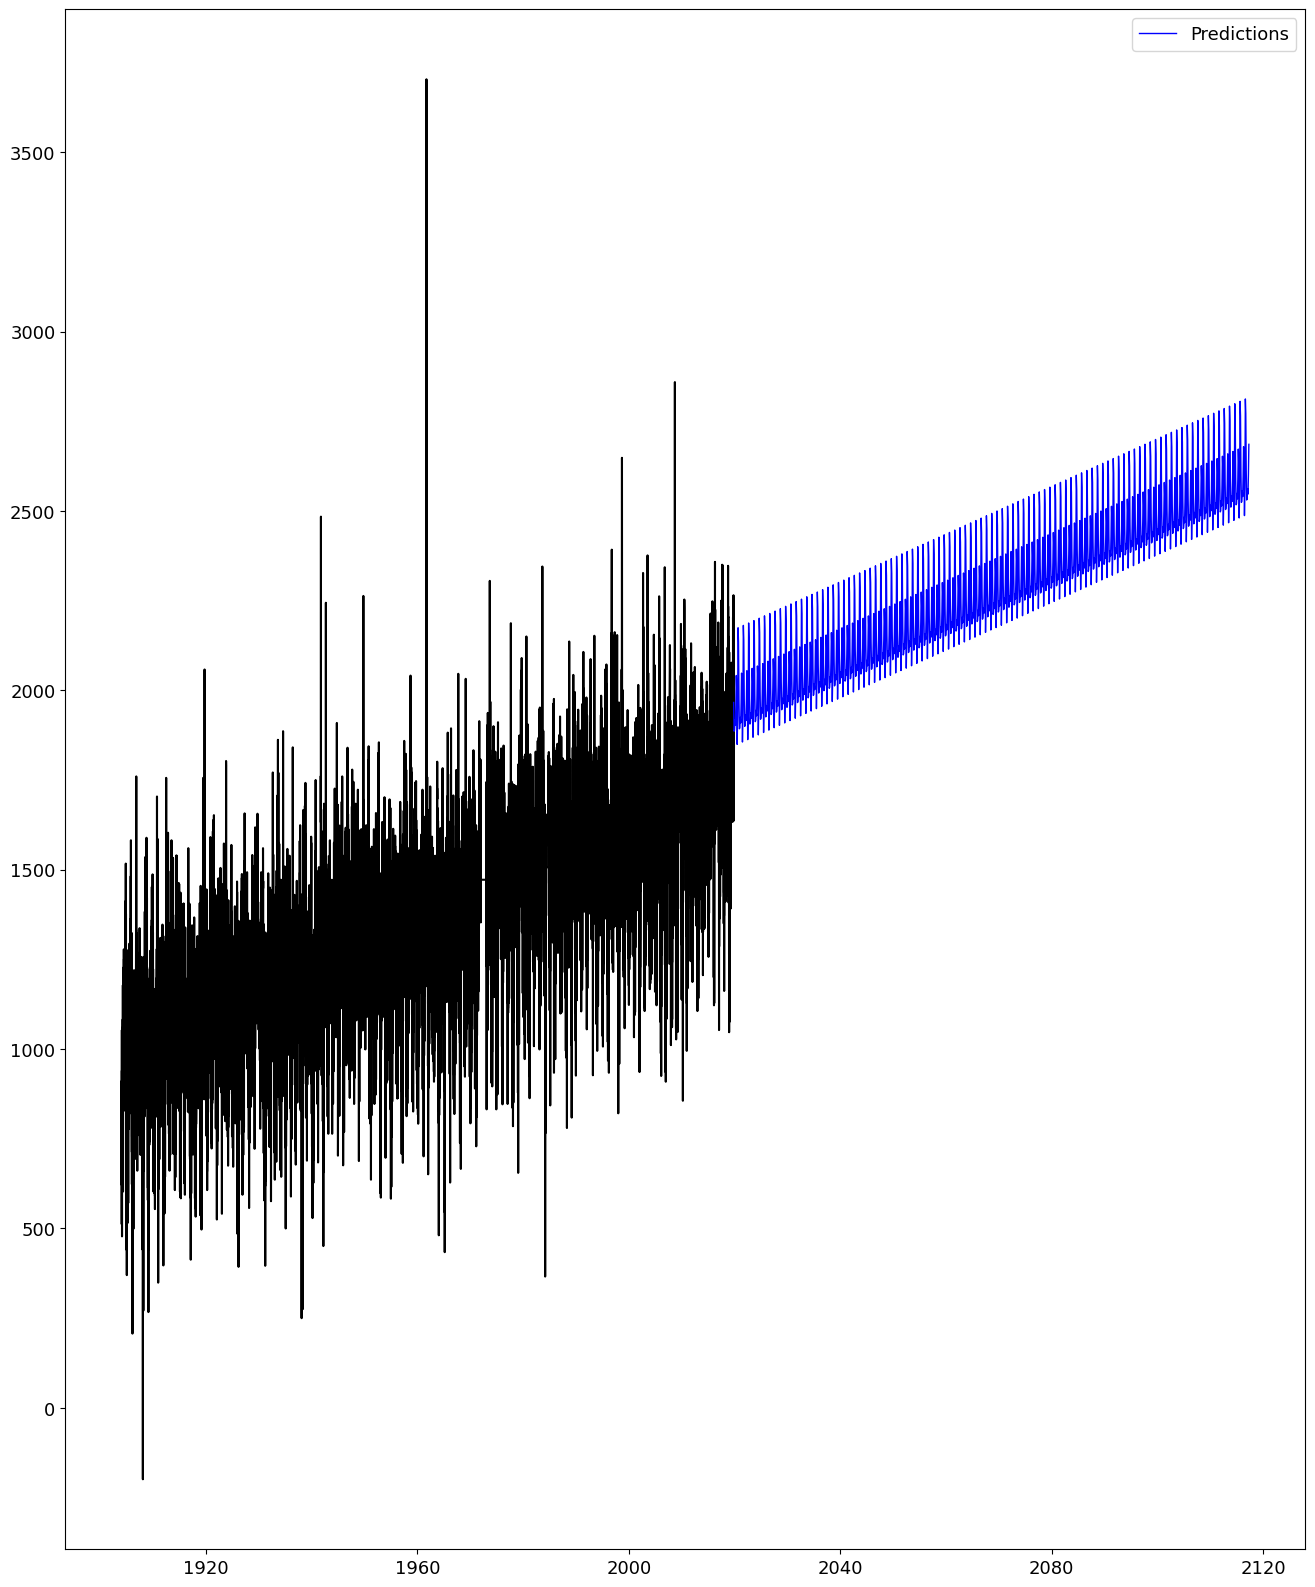

In [126]:

#plt.plot(series, color = "blue")

plt.plot(series, color = "black")
#plt.plot(test, color = "red")
#plt.plot(y_pred_out, color='green', label = 'Predictions', linewidth= 5 )
plt.plot( future_series.index, total_sum_preds , color='blue', label = 'Predictions', linewidth= 1 )
#plt.plot(y_pred_df2['lower sea_level'], color='yellow', label = 'Predictions', linewidth= 2 )
#plt.plot(y_pred_df2['upper sea_level'], color='yellow', label = 'Predictions', linewidth= 2 )



plt.legend()


In [109]:
y_pred_df2

,lower sea_level,upper sea_level,Predictions
2000-12-31,1553.693871,2686.376404,2120.035138
2001-12-31,1641.119062,2772.017212,2206.568137
2002-12-31,1567.460618,2698.717994,2133.089306
2003-12-31,1592.709098,2723.941768,2158.325433
2004-12-31,1610.263521,2741.498500,2175.881010
...,...,...,...
2064-12-31,1961.734153,3202.228065,2581.981109
2065-12-31,1976.687582,3217.181521,2596.934551
2066-12-31,1980.726010,3221.220034,2600.973022
2067-12-31,1965.058509,3205.552611,2585.305560


In [265]:

X0    = series.resample('M').mean()

X1    = series.resample('Y').mean()

X2    = series.resample('Y').max()
X3    = series.resample('Y').min()

len(X1)

train, test   =  X1[1:len(X1)- 10 ], X1[len(X1)- 10:]
trainT, testT = time[1:len(X1) -  10], time[len(X1)- 10:]



In [282]:
SARIMAXmodel5 = SARIMAX(X2, order = (1, 1, 1), seasonal_order=( 1, 1, 1, 60 ))
SARIMAXmodel5 = SARIMAXmodel5.fit()
SARIMAXmodel6 = SARIMAX(X3, order = (1, 1, 1), seasonal_order=( 1, 1, 1, 60 ))
SARIMAXmodel6 = SARIMAXmodel6.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39401D+00    |proj g|=  5.57964D-02

At iterate    5    f=  3.35400D+00    |proj g|=  5.49937D-03

At iterate   10    f=  3.35100D+00    |proj g|=  5.10776D-04

At iterate   15    f=  3.32801D+00    |proj g|=  5.59922D-02

At iterate   20    f=  3.31298D+00    |proj g|=  2.32666D-02

At iterate   25    f=  3.31077D+00    |proj g|=  4.87902D-03

At iterate   30    f=  3.30960D+00    |proj g|=  3.43472D-03

At iterate   35    f=  3.30898D+00    |proj g|=  1.70177D-03

At iterate   40    f=  3.30863D+00    |proj g|=  3.32507D-03

At iterate   45    f=  3.30848D+00    |proj g|=  1.15986D-03

At iterate   50    f=  3.30835D+00    |proj g|=  1.05125D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27573D+00    |proj g|=  5.12465D-02

At iterate    5    f=  3.26123D+00    |proj g|=  2.07979D-02

At iterate   10    f=  3.25546D+00    |proj g|=  1.04947D-03

At iterate   15    f=  3.25503D+00    |proj g|=  1.01349D-03

At iterate   20    f=  3.25258D+00    |proj g|=  5.40642D-03

At iterate   25    f=  3.24239D+00    |proj g|=  2.05708D-02

At iterate   30    f=  3.24001D+00    |proj g|=  7.96254D-03

At iterate   35    f=  3.23897D+00    |proj g|=  1.96388D-03

At iterate   40    f=  3.23859D+00    |proj g|=  2.30706D-03

At iterate   45    f=  3.23836D+00    |proj g|=  1.67808D-03

At iterate   50    f=  3.23826D+00    |proj g|=  1.38342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [266]:
SARIMAXmodel4 = SARIMAX(X1, order = (1, 1, 1), seasonal_order=( 1, 1, 1, 60 ))
SARIMAXmodel4 = SARIMAXmodel4.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63887D+00    |proj g|=  2.27700D-02


 This problem is unconstrained.



At iterate    5    f=  2.63789D+00    |proj g|=  1.43142D-03

At iterate   10    f=  2.63503D+00    |proj g|=  3.22313D-03

At iterate   15    f=  2.63290D+00    |proj g|=  1.35888D-03

At iterate   20    f=  2.63215D+00    |proj g|=  2.81611D-03

At iterate   25    f=  2.63190D+00    |proj g|=  3.59966D-03

At iterate   30    f=  2.63180D+00    |proj g|=  2.15896D-03

At iterate   35    f=  2.63175D+00    |proj g|=  2.40462D-03

At iterate   40    f=  2.63170D+00    |proj g|=  1.71601D-04

At iterate   45    f=  2.63167D+00    |proj g|=  1.30175D-03

At iterate   50    f=  2.63166D+00    |proj g|=  6.63645D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [333]:
future_dates = pd.date_range(start= X1.index[-1], periods= 60, freq='y')
total_predict_dates = test.index.union(future_dates)

y_pred4 = SARIMAXmodel4.get_forecast( len( total_predict_dates)  )
y_pred_df4 = y_pred4.conf_int(alpha = 0.05) 
y_pred_df4["Predictions"] = ( y_pred_df4['lower sea_level'] + y_pred_df4['upper sea_level'] )/2
#SARIMAXmodel4.predict(start = total_predict_dates[0], 
#                                                 end = total_predict_dates[-1])
y_pred_df4

,lower sea_level,upper sea_level,Predictions
2020-12-31,1636.667178,1876.321875,1756.494526
2021-12-31,1663.762605,1923.183751,1793.473178
2022-12-31,1590.039746,1851.654757,1720.847252
2023-12-31,1567.189741,1816.911877,1692.050809
2024-12-31,1686.881925,1815.860407,1751.371166
...,...,...,...
2084-12-31,2014.131917,2147.460356,2080.796137
2085-12-31,2081.093272,2214.413064,2147.753168
2086-12-31,2056.038048,2189.354410,2122.696229
2087-12-31,2099.915431,2233.230435,2166.572933


In [334]:

y_pred_df4.index = total_predict_dates 
y_pred_out4 = y_pred_df4["Predictions"] 

print("RMSE: ", SARIMAXmodel4)


################
y_pred5 = SARIMAXmodel5.get_forecast( len( future_dates)  )
y_pred_df5 = y_pred5.conf_int(alpha = 0.05) 
y_pred_df5["Predictions"] = SARIMAXmodel5.predict(start = future_dates[0], 
                                                 end = future_dates[-1])

y_pred_df5.index = future_dates 
y_pred_out5 = y_pred_df5["Predictions"] 

#######################################################################################
y_pred6 = SARIMAXmodel6.get_forecast( len( future_dates)  )
y_pred_df6 = y_pred6.conf_int(alpha = 0.05) 
y_pred_df6["Predictions"] = SARIMAXmodel6.predict(start = future_dates[0], 
                                                 end = future_dates[-1])

y_pred_df6.index = future_dates 
y_pred_out6 = y_pred_df6["Predictions"] 

########################################################################################
SARIMAX_rmse = np.sqrt(mean_squared_error( test.values, 
                                           y_pred_df4["Predictions"][:len(test.values)]))
print("RMSE: ", SARIMAX_rmse)

lowersl = y_pred_df4['lower sea_level'][len(test):]
uppersl = y_pred_df4['upper sea_level'][len(test):]


RMSE:  <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x2a94bc510>
RMSE:  79.72986505789974


In [335]:

n = 4

upper_rolmean = y_pred_df4['upper sea_level'].rolling( n ).mean()
lower_rolmean = y_pred_df4['lower sea_level'].rolling( n ).mean()

n2 = 8
obs_preds = pd.concat( [X1, y_pred_out4[len(test):] ] )
rolmean = obs_preds.rolling( n2 ).mean()
#plt.scatter(X0.index, X0.values, color = "blue")
from scipy.interpolate import splrep, BSpline
tck1 = splrep( upper_rolmean.index, upper_rolmean.values, s= len(upper_rolmean.index))
tck2 = splrep( lower_rolmean.index, lower_rolmean.values, s= len(upper_rolmean.index))

#tck_s = splrep(x, y, s=len(x))

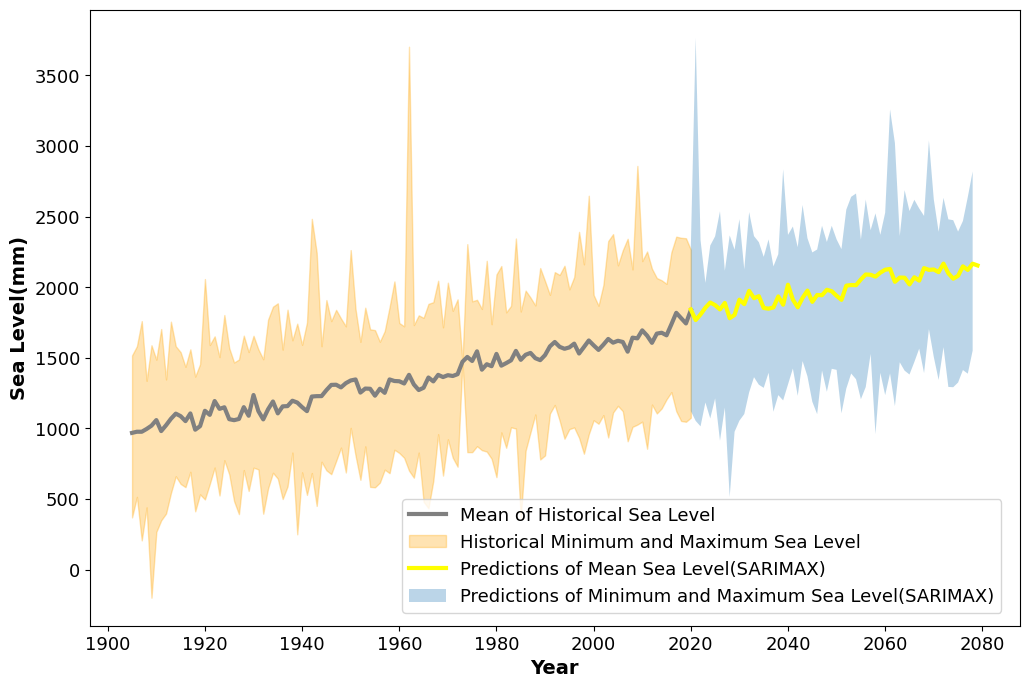

In [345]:
#rolstd = obs_preds.rolling( n ).std()
fig, ax = plt.subplots( figsize=(12, 8) )

plt.plot(X1, color='gray',label='Mean of Historical Sea Level', linewidth= 3)
plt.fill_between( X1.index, X2.values, X3.values, 
                  color = 'orange', alpha = 0.3, label='Historical Minimum and Maximum Sea Level')


#plt.scatter(rolmean.index, rolmean.values, color='black', label='Rolling Mean', s=2)
#plt.plot(test, color = "red")
#plt.plot(y_pred_out, color='green', label = 'Predictions', linewidth= 5 )
plt.plot( y_pred_out4 [len(test)-1:] , color='yellow', label = 'Predictions of Mean Sea Level(SARIMAX)', linewidth= 3 )
#plt.plot(upper_rolmean.index, upper_rolmean.values, color='darkred', label = 'Predictions' )
#plt.plot(lower_rolmean.index, lower_rolmean.values, color='darkred', label = 'Predictions' )
#plt.plot(upper_rolmean.index, BSpline(*tck1)(upper_rolmean.index), color='darkred', label = 'Predictions' )
#plt.plot(lower_rolmean.index, BSpline(*tck2)(lower_rolmean.index), color='darkred', label = 'Predictions' )
plt.fill_between( y_pred_out6.index, y_pred_out6.values, 
                  y_pred_out5.values, alpha = 0.3, 
                  label = 'Predictions of Minimum and Maximum Sea Level(SARIMAX)')
plt.legend( bbox_to_anchor=(0.99,0.22) )
#plt.title('Rolling Mean & Standard Deviation')
plt.xlabel("Year", weight = 'bold', fontsize= 14)
plt.ylabel("Sea Level(mm)", weight = 'bold', fontsize= 14)
#plt.savefig('../output_images/Predict_Future_Sea_Level.pdf',dpi=300, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/Predict_Future_Sea_Level.pdf', format="pdf", bbox_inches="tight")

plt.show(block=False)


#plt.legend()

In [328]:
y_pred_df4

,lower sea_level,upper sea_level,Predictions
2010-12-31,1636.667178,1876.321875,1756.494526
2011-12-31,1663.762605,1923.183751,1793.473178
2012-12-31,1590.039746,1851.654757,1720.847252
2013-12-31,1567.189741,1816.911877,1692.050809
2014-12-31,1686.881925,1815.860407,1751.371166
...,...,...,...
2074-12-31,2014.131917,2147.460356,NaN
2075-12-31,2081.093272,2214.413064,NaN
2076-12-31,2056.038048,2189.354410,NaN
2077-12-31,2099.915431,2233.230435,NaN


In [211]:
y_pred_df4.to_csv( r"../data/gaugestation/sealevel_annual_galveston_pred.csv" , index = True)

In [210]:
total_data = pd.DataFrame()
total_data['time'] = obs_preds.index
total_data['sealevel'] = obs_preds.values
total_data['rollmean'] = rolmean.values
y_pred_df4.to_csv( r"../data/gaugestation/sealevel_annual_galveston_obs_pred.csv" , index = True)


In [1]:
2154.343937 - 1756.494526
#0.4 m

397.84941100000015